# Challenge: Using Data to Optimize Logistics  

# Description    
Your friend owns a small logistics company that specializes in shipping goods across the country. They have been using a manual system to track their shipments, but with the growing number of shipments, they need a more efficient way to manage their data. They have asked for your help to analyze their shipment data and provide insights on how to improve their business.  

### Tasks  
- Task 1: **Shipment Time Analysis** - Your friend wants to know the average time it takes for shipments to arrive at their destination. Use the dataset to calculate the average shipment time and identify the top 5 routes with the longest shipment times.  
- Task 2: **Package Weight Distribution** - Your friend wants to optimize their packaging process. Use the dataset to calculate the distribution of package weights and identify the most common weight range.  
- Task 3: **Shipper Performance Analysis** - Your friend wants to evaluate the performance of their shippers. Use the dataset to calculate the on-time delivery rate for each shipper and identify the top 3 shippers with the highest on-time delivery rates.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
Pandas version 2.2.1
Numpy version 1.26.4


# The Data  

The code below generates data that represents a bunch of shipments, with details about who's shipping them, where they're going, how heavy they are, and when they were sent and delivered.  

### Columns:  
- **shipment_id:** This is a unique identifier for each shipment  
- **shipper:** This is the company that's handling the shipment  
- **origin:** This is the city where the shipment starts its journey  
- **destination:** This is the city where the shipment is headed  
- **package_weight (kg):** This is how heavy the package is, in kilograms  
- **shipment_date:** This is the date when the shipment was sent out  
- **delivery_date:** This is the date when the shipment was delivered

I'll be honest, I had to do a bit of massaging the data here. I had issues generating dates that looked realistic, with some being too far in the future, but I eventually got something that looks realistic enough for this tutorial.

In [2]:
# set the seed
np.random.seed(0)

# number of data points to generate
shipments = 10000

data = {
    'shipment_id': range(1, shipments+1),
    'shipper': np.random.choice(['Shipper A', 'Shipper B', 'Shipper C'], shipments),
    'origin': np.random.choice(['City A', 'City B', 'City C'], shipments),
    'destination': np.random.choice(['City D', 'City E', 'City F'], shipments),
    'package_weight': np.random.uniform(1, 100, shipments),
    'shipment_date': pd.date_range('2020-01-01', '2024-01-01', periods=shipments)
}

# create dataframe
df = pd.DataFrame(data)

# generate the delivery_date column
df['delivery_date'] = df['shipment_date'] + pd.to_timedelta(np.random.randint(1, 30, shipments), unit='days')

# remove timestamps
df['delivery_date'] = pd.to_datetime(df['delivery_date'].dt.date)
df['shipment_date'] = pd.to_datetime(df['shipment_date'].dt.date)

df

,shipment_id,shipper,origin,destination,package_weight,shipment_date,delivery_date
0,1,Shipper A,City C,City F,73.070940,2020-01-01,2020-01-25
1,2,Shipper B,City A,City E,30.918563,2020-01-01,2020-01-27
2,3,Shipper A,City C,City E,84.603849,2020-01-01,2020-01-08
3,4,Shipper B,City C,City E,16.533795,2020-01-01,2020-01-05
4,5,Shipper B,City B,City D,16.895606,2020-01-01,2020-01-08
...,...,...,...,...,...,...,...
9995,9996,Shipper A,City C,City D,71.514309,2023-12-31,2024-01-12
9996,9997,Shipper B,City B,City F,9.918157,2023-12-31,2024-01-11
9997,9998,Shipper B,City B,City E,26.531780,2023-12-31,2024-01-11
9998,9999,Shipper A,City A,City E,53.675512,2023-12-31,2024-01-05


Let's take a look at the datatypes and make sure they look 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   shipment_id     10000 non-null  int64         
 1   shipper         10000 non-null  object        
 2   origin          10000 non-null  object        
 3   destination     10000 non-null  object        
 4   package_weight  10000 non-null  float64       
 5   shipment_date   10000 non-null  datetime64[ns]
 6   delivery_date   10000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 547.0+ KB


# Shipment Time Analysis  

Your friend wants to know the average time it takes for shipments to arrive at their destinations. Use the dataset to calculate the average shipment time and identify the top 5 routes with the longest shipment times.

In [4]:
# calculate the total shipment time
df['total_shipment_time'] = df['delivery_date'] - df['shipment_date']
df.head()

,shipment_id,shipper,origin,destination,package_weight,shipment_date,delivery_date,total_shipment_time
0,1,Shipper A,City C,City F,73.070940,2020-01-01,2020-01-25,24 days
1,2,Shipper B,City A,City E,30.918563,2020-01-01,2020-01-27,26 days
2,3,Shipper A,City C,City E,84.603849,2020-01-01,2020-01-08,7 days
3,4,Shipper B,City C,City E,16.533795,2020-01-01,2020-01-05,4 days
4,5,Shipper B,City B,City D,16.895606,2020-01-01,2020-01-08,7 days


Let's take a closer look at the **total_shipment_time** column using the `describe()` method.  

I also pulled the days out of the timedelta column named total_shipment_time. This allows me to get descriptive statistics on a number versus a date object.  

To answer the first part of the question, **the average shipment time is 15 days**.

In [5]:
df['total_shipment_time'].dt.days.describe()

count    10000.000000
mean        15.009000
std          8.385508
min          1.000000
25%          8.000000
50%         15.000000
75%         22.000000
max         29.000000
Name: total_shipment_time, dtype: float64

For the second part of the question, I thought all we had to do was order the dataframe and pull out the top 5 rows.  

The issue is that we need to find the unique routes and the top 5 rows had duplicates. So I cheated a bit and just pulled more rows and removed the dupes.  

What should I have done here?

In [6]:
df.sort_values(by='total_shipment_time', ascending=False).head(8)[['origin','destination']].drop_duplicates()

,origin,destination
9999,City A,City E
5156,City C,City D
6480,City B,City D
6418,City B,City F
889,City B,City E


# Package Weight Distribution  

Your friend wants to optimize their packaging process. Use the dataset to calculate the distribution of package weights and identify the most common weight range.  

From the statistics below, most of the packages weigh between 25KG and 75KG. 

In [7]:
df['package_weight'].describe()

count    10000.000000
mean        50.532313
std         28.634233
min          1.034149
25%         25.625208
50%         51.006958
75%         75.310373
max         99.985707
Name: package_weight, dtype: float64

Let's plot the data to confirm. This would also be a good chart to show my friend and explain where most of the weights fall under.

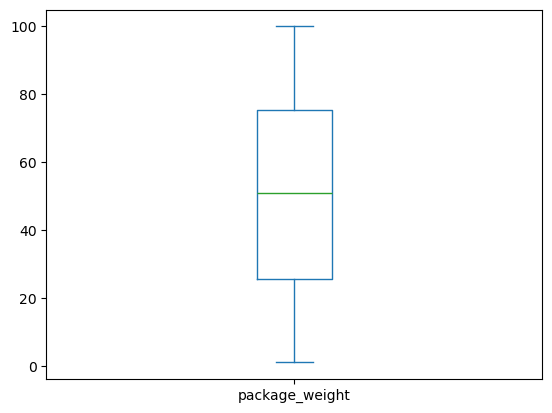

In [8]:
df['package_weight'].plot.box();

# Shipper Performance Analysis  

Your friend wants to evaluate the performance of their shippers. Use the dataset to calculate the on-time delivery rate for each shipper and identify the top 3 shippers with the highest on-time delivery rates.

In [9]:
# clean up data for analysis
# using .copy() to avoid issues creating a new column and setting it to a copy of the dataframe
shipper = df[['shipper', 'total_shipment_time']].copy()
shipper['total_days'] = shipper['total_shipment_time'].dt.days

# drop total_shipment_time
del shipper['total_shipment_time']

# create grouping object
group = shipper.groupby('shipper')

# calculate the median against group
group.median()['total_days']

shipper
Shipper A    15.0
Shipper B    15.0
Shipper C    15.0
Name: total_days, dtype: float64

Unfortunately, synthetic data is not always the greatest. It seems that my friend can use any shipper, as they all perform basically the same.

In [10]:
group.describe()

total_days                                                 
               count       mean       std  min  25%   50%   75%   max
shipper                                                              
Shipper A     3347.0  14.873319  8.485110  1.0  7.0  15.0  22.0  29.0
Shipper B     3413.0  15.060357  8.331348  1.0  8.0  15.0  22.0  29.0
Shipper C     3240.0  15.095062  8.339595  1.0  8.0  15.0  22.0  29.0

<p class="text-muted">This tutorial was created by <a href="https://www.hedaro.com" target="_blank"><strong>HEDARO</strong></a></p>